H0: MSE_js_est >= MSE_mle vs. H1: MSE_js_est < MSE_mle
p-value 0.0000
====> js likely better <====


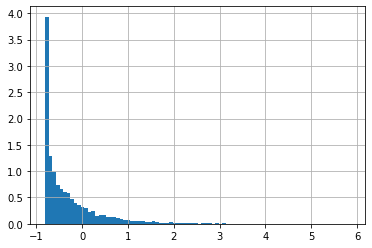

In [77]:
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt

p = 3
n = 10


mcov = np.diag(1+np.arange(p))
mcov[1,1] *= 2
mmu = np.arange(p)*0

dist = stats.multivariate_normal(mean=mmu, cov=mcov)


def james_stein0(est, p, n, vol):
    shrinkage = (1-(p-2)/n*vol**2 / np.linalg.norm(est, ord=2)**2)
    shrinkage = max(shrinkage, 0)
    return shrinkage * est

def james_stein(est, n, mcov, guess=None):
    ''' Specify guess for location other than at origin. '''
    guess = np.zeros(mcov.shape[0]) if guess is None else guess
    p = mcov.shape[0]
    shrinkage = 1-(p-2)/((est-guess) @ np.linalg.inv(mcov) @ est)/n
    shrinkage = max(shrinkage, 0)
    return guess + shrinkage * (est - guess)

def sqloss(est, target, mcov=None):
    ''' Specify mcov for cov invariant squared loss.'''
    mcov = np.eye(len(est)) if mcov is None else mcov
    return (est - target) @ np.linalg.pinv(mcov) @ (est - target)

nsim = 5000
mse = np.empty(nsim)
for i in range(nsim):
    X = dist.rvs(n)
    mle = np.mean(X, axis=0)
    mcov_est = np.cov(X, rowvar=False, ddof=1)
    js = james_stein(mle, n, mcov_est)
    mse[i] = sqloss(js, mmu)
    
mse_mle = np.trace(mcov)/n
mse_js_mu = (np.mean(mse), np.var(mse, ddof=1)/nsim )
plt.hist(mse - mse_mle, bins='auto', density=True)
plt.grid()
zscore = (mse_js_mu[0] - mse_mle) / np.sqrt(mse_js_mu[1])
pval = stats.norm.cdf(zscore)
print('H0: MSE_js_est >= MSE_mle vs. H1: MSE_js_est < MSE_mle')
print('p-value {:.4f}'.format(pval))
print('====> js likely better <====') if pval < 0.05 else print('mle likely better')